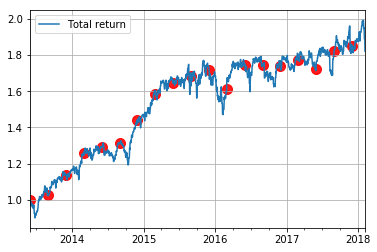

Calmar ratio:  6.09802435524296 , MAR ratio:  0.4566720753724066


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import os

warnings.simplefilter('ignore')


def max_DD(x):
    i = np.argmax(np.maximum.accumulate(x) - x) 
    j = np.argmax(x[:i]) 
    return (x[i] - x[j])


def backtest_ranking_EDGAR(score_file = "frac_score_3mnth.csv", p = 5, transaction_cost_bips = 10.0):
    
    dividends_df = {}
    sectors_info = pd.read_csv("sectors.csv")
    tickers = sectors_info["TICKER"].values
    
    for ticker in tickers:
        
        try:
            div_df = pd.read_csv(os.path.join(os.path.abspath("div_data"),\
                                                       ticker+".csv"))
            div_df.index = pd.to_datetime(div_df["Ex-Date"])
            dividends_df[ticker] = div_df
        except Exception as e:
            pass

    
    
    score_original = pd.read_csv(score_file, index_col = 0)
    market_data_original = pd.read_csv("market_data_daily_resample_close.csv", index_col = 0).ffill()
    score_original.index = pd.to_datetime(score_original.index)
    market_data_original.index = pd.to_datetime(market_data_original.index)
    
    tickers_intersection = list(set.intersection(set(market_data_original.columns),\
                                                 set(score_original.columns)))
    
    market_data = market_data_original[tickers_intersection]
    score = score_original[tickers_intersection]
    total_return = 1.0
    rebalance_dates = score.index
    long_positions = [] 
    history_long = []    
    active_return = []
    active_dates = []
    rebalance_active_return = []
    rebalance_active_dates = []
    dates_union = rebalance_dates.union(market_data.index)
    dates_union = dates_union[dates_union >= rebalance_dates[0]]
    dates_union = dates_union[dates_union <= market_data.index[-1]]
    market_data = market_data.reindex(dates_union).ffill()
    quartal_return = []

    
    for date in dates_union:
        
        new_total_return = total_return
        
        for long_pos in long_positions:
            
            long_ticker = long_pos[0]
            long_px = long_pos[1]
            
            if long_ticker in market_data.columns:
                current_px = market_data.loc[date][long_ticker]
                pos_size = total_return / p
                new_total_return += pos_size * (current_px - long_px) / long_px -\
                    pos_size * 2 * (transaction_cost_bips/10000.0)
                 
                if long_ticker in dividends_df.keys():
                    
                    if date in dividends_df[long_ticker].index:
                        
                        if dividends_df[long_ticker].loc[date]["Dividend Type"] == "Regular Cash":

                            new_total_return += dividends_df[long_ticker].loc[date]["Dividend Amount"] / long_px
                  
        active_dates.append(date)
        active_return.append(new_total_return)
        
        
        if date in rebalance_dates:
            
            quartal_return.append(new_total_return / total_return)
            total_return = new_total_return
            rebalance_active_return.append(total_return)
            rebalance_active_dates.append(date)
            
            cur_px_tickers = set(list(market_data.loc[date].dropna().index))
            cur_score_tickers = set(list(score.loc[date].dropna().index))
            cur_tickers_intersection = np.array(list(set.intersection(cur_px_tickers,\
                                                 cur_score_tickers)))
            cur_ranks = score.loc[date][cur_tickers_intersection].values
            cur_px = market_data.loc[date][cur_tickers_intersection]
            ranks_argsort = np.argsort(cur_ranks)
            long_tickers = list(cur_tickers_intersection[ranks_argsort[-p:]])
            long_positions = []
            
            for x in long_tickers:
                if x in market_data.columns:
                    long_positions.append((x, cur_px[x]))
                       
            history_long.append((date.date(), long_tickers))
            
            
    ax = plt.gca()
    
            
    return_series = pd.Series(data = active_return, index = active_dates)
    return_series.plot(legend = True, ax = ax, label = "Total return", grid = True)
    plt.scatter(label = "Rebalance points", x = rebalance_active_dates,\
                y = rebalance_active_return, c='red', s=100, alpha=0.9)
    plt.show()
    DD = max_DD(active_return)
    calmar_ratio = active_return[-1] / (.0 + np.abs(DD))
    CAGR = pow(active_return[-1], 1.0/((active_dates[-1] - active_dates[0]).days / 365.0)) - 1.0
    MAR_ratio = CAGR / (.0 + np.abs(DD))
    
    print("Calmar ratio: ", calmar_ratio, ", MAR ratio: ", MAR_ratio)
        
    return (history_long, total_return)
        
        
history_long, total_return =  backtest_ranking_EDGAR(p = 5)   

In [14]:
#Portfolio history

for record in history_long:
    print(record, '\n')

(datetime.date(2013, 5, 31), ['NTAP', 'ADSK', 'FFIV', 'AAPL', 'WDC']) 

(datetime.date(2013, 8, 31), ['SIG', 'MHK', 'ORLY', 'SHW', 'HOG']) 

(datetime.date(2013, 11, 30), ['SIG', 'MHK', 'SHW', 'ORLY', 'HOG']) 

(datetime.date(2014, 2, 28), ['SIG', 'MHK', 'HOG', 'SHW', 'ORLY']) 

(datetime.date(2014, 5, 31), ['TDG', 'HOG', 'MHK', 'SHW', 'ORLY']) 

(datetime.date(2014, 8, 31), ['TDG', 'HOG', 'SHW', 'MHK', 'ORLY']) 

(datetime.date(2014, 11, 30), ['HOG', 'TDG', 'SHW', 'MHK', 'ORLY']) 

(datetime.date(2015, 2, 28), ['SIG', 'TDG', 'SHW', 'MHK', 'ORLY']) 

(datetime.date(2015, 5, 31), ['TDG', 'SHW', 'SIG', 'MHK', 'ORLY']) 

(datetime.date(2015, 8, 31), ['SHW', 'TDG', 'SIG', 'MHK', 'ORLY']) 

(datetime.date(2015, 11, 30), ['MTD', 'IDXX', 'MHK', 'SIG', 'ORLY']) 

(datetime.date(2016, 2, 29), ['IDXX', 'ORLY', 'MTD', 'MHK', 'SIG']) 

(datetime.date(2016, 5, 31), ['PAYX', 'TMO', 'MHK', 'XRAY', 'SIG']) 

(datetime.date(2016, 8, 31), ['MTD', 'MHK', 'PAYX', 'SIG', 'XRAY']) 

(datetime.date(2016, 11,